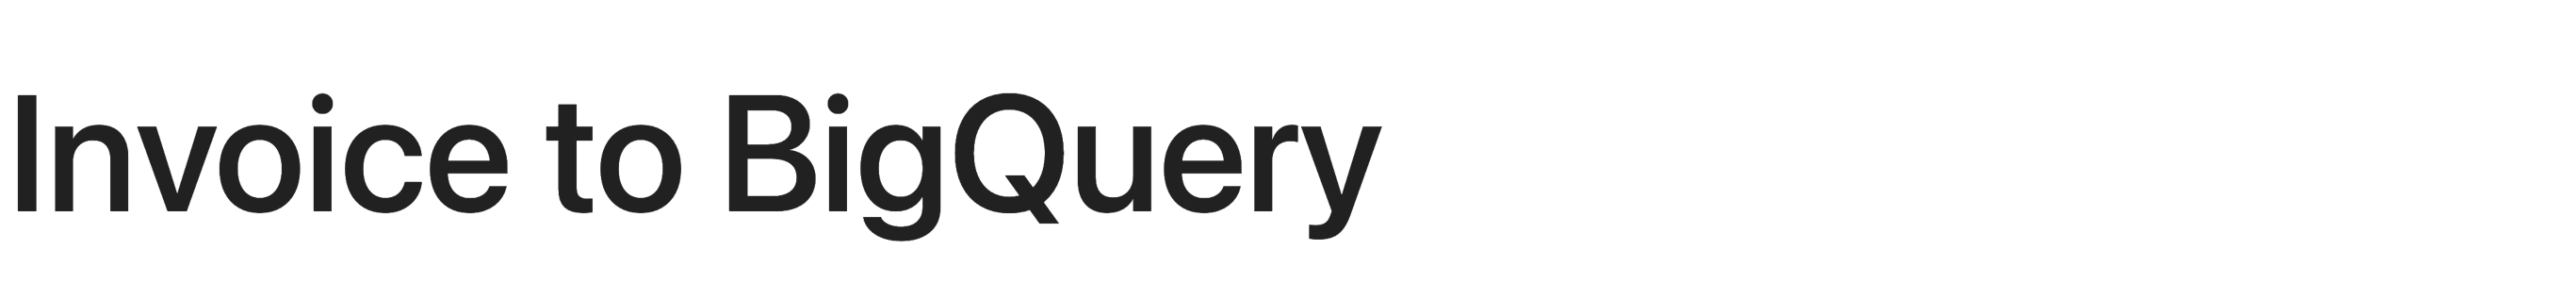

# Codelab : Document AI : Saving Invoice to BigQuery

# I. Download Invoice

##### <i> More Sample Invoices: https://github.com/GoogleCloudPlatform/documentai-notebooks/tree/master/resources/procurement/invoices

In [1]:
# download a single invoice
!rm -rf invoice.pdf
invoice_url = 'https://github.com/GoogleCloudPlatform/documentai-notebooks/raw/master/resources/procurement/invoices/invoice.pdf'
!wget -q $invoice_url
!ls -l invoice.pdf

-rw-r--r-- 1 jupyter jupyter 219122 Mar 31 01:12 invoice.pdf


In [2]:
INVOICE_PDF = 'invoice.pdf'

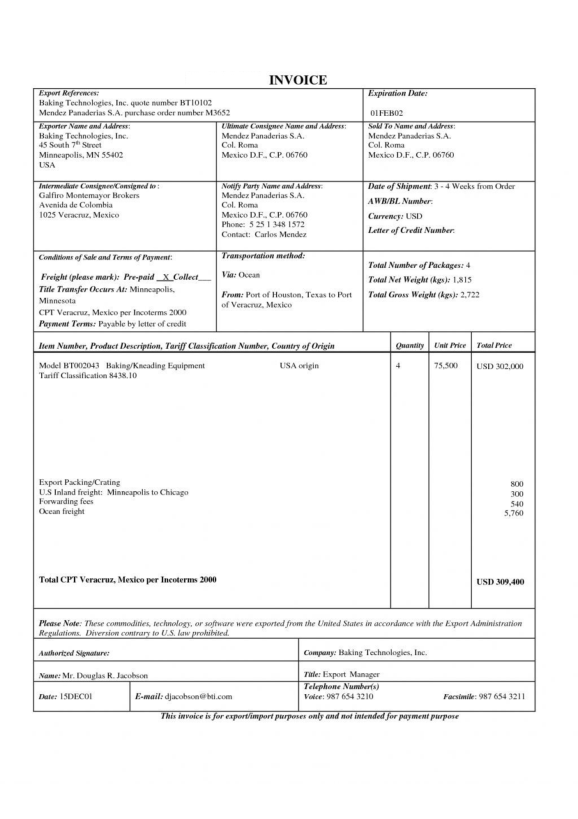

In [5]:
from wand.image import Image  
Image(filename=INVOICE_PDF, resolution=70)

# II. Process Invoice

### 1. Call Document AI

In [10]:
from google.cloud import documentai_v1beta3 as documentai

PROJECT_ID = 'doc-ai-ce'
PROCESSOR_ID = 'e38c82311d145f3b'
LOCATION = 'us'
name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

with open(INVOICE_PDF, "rb") as image:
    document = {"content": image.read(), "mime_type": "application/pdf"}
    request = {"name": name, "document": document}
    
results = documentai.DocumentProcessorServiceClient().process_document(request=request)

### 2. Gather Entities

In [11]:
import pandas as pd

results_frame = [[entity.type_, entity.mention_text, round(entity.confidence, 4)] for entity in results.document.entities]
df = pd.DataFrame(results_frame, columns=['type', 'value','confidence'])
df.head(3)

,type,value,confidence
0,invoice_date,15DEC01,0.9615
1,purchase_order,M3652,0.9404
2,total_amount,"309,400",0.8316


### 3. Transform Data

In [12]:
df_t = df.rename(columns={'type':'index'}).drop(columns=['confidence']).T
df_t.columns = df_t.iloc[0]
df_t = df_t.drop(df_t.index[0])
df_t = df_t.reset_index(drop=True) 
df_t = df_t[['purchase_order','invoice_date', 'total_amount','net_amount','currency']]
df_t['invoice_date'] = pd.to_datetime(df_t['invoice_date'])

for num_col in ['total_amount', 'net_amount']:
    df_t[num_col] = pd.to_numeric(df_t[num_col].str.replace(',',''))

df_t

index,purchase_order,invoice_date,total_amount,net_amount,currency
0,M3652,2001-12-15,309400,1815,USD


# III. Save to BigQuery

### 1. Create BigQuery Dataset

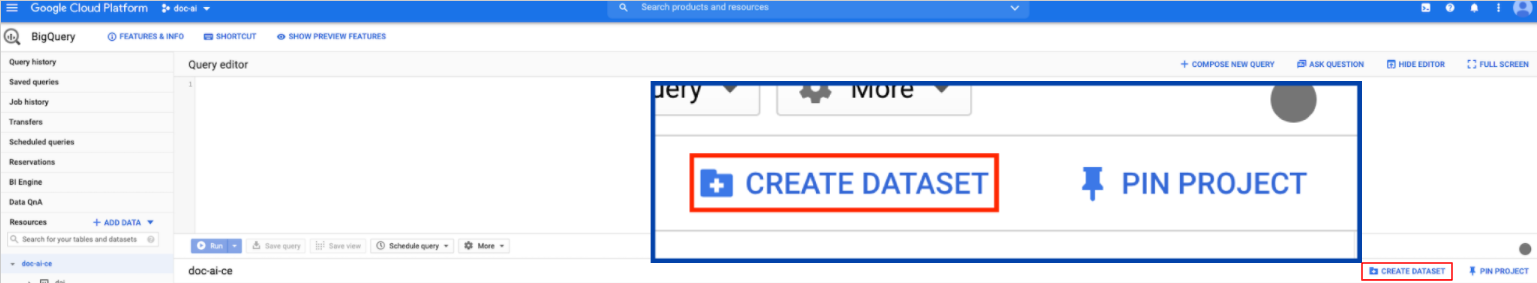

##### <i>Instructions and Pics Here</i>
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### 2. Insert Invoice into BigQuery

In [18]:
from google.cloud import bigquery

DATASET = 'dai'
TABLE = 'invoice'

bq = bigquery.Client(project=PROJECT_ID)

In [19]:
bq.delete_table(f'{DATASET}.{TABLE}', not_found_ok=True)

In [20]:
job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("purchase_order", "STRING"),
    bigquery.SchemaField("invoice_date", "DATE"),
    bigquery.SchemaField("total_amount", "FLOAT"),
    bigquery.SchemaField("net_amount", "FLOAT"),
    bigquery.SchemaField("currency", "STRING")
])

job = bq.load_table_from_dataframe(df_t, f'{DATASET}.{TABLE}', job_config=job_config)
job.result().state

'DONE'

### 3. Verify Data
##### query back the newly inserted data
https://pantheon.corp.google.com/bigquery?project=doc-ai-ce&p=doc-ai-ce&d=dai&t=invoice&page=table

In [21]:
bq.query(f'SELECT * FROM {DATASET}.{TABLE}').to_dataframe()

,purchase_order,invoice_date,total_amount,net_amount,currency
0,M3652,2001-12-15,309400.0,1815.0,USD
